# French presidents' popularity

In [1]:
import datetime

import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt

## Exploratory data analysis

In [54]:
data = pd.read_csv('./plot_data/raw_polls.csv', parse_dates = True, index_col="Unnamed: 0")
data['year'] = data.index.year
data['month'] = data.index.month
data['month_name'] = data.index.month_name()
data['sondage'] = data['sondage'].replace('Yougov', 'YouGov')
print("columns: ", data.columns, "\n")

minimum = np.min(data[["year"]].values)
maximum = np.max(data[["year"]].values)
pollsters = data["sondage"].unique()

comment = f"""The dataset contains {len(data)} polls between the years {minimum} and {maximum}.
There are {len(pollsters)} pollsters: {', '.join(list(pollsters))}
"""
print(comment)

columns:  Index(['president', 'sondage', 'samplesize', 'method', 'p_approve',
       'p_disapprove', 'year', 'month', 'month_name'],
      dtype='object') 

The dataset contains 1052 polls between the years 2002 and 2021.
There are 10 pollsters: Ifop, Kantar, BVA, Ipsos, Odoxa, Elabe, Viavoice, YouGov, Harris, OpinionWay



In [55]:
print(data[data.president == "macron"].shape)
print(data[data.president == "macron"].index.to_period('M').shape)
pd.Categorical(data[data.president == "macron"].index.to_period('M')).codes

(355, 9)
(355,)


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13,
       13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15,
       15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 26, 26, 26, 26

In [56]:
pd.Categorical(data["sondage"]).codes

array([3, 5, 0, ..., 4, 5, 1], dtype=int8)

Let us look at simple stats on the pollsters. First the total number of polls they've produced:

In [57]:
data["sondage"].value_counts()

Ifop          239
Ipsos         215
Kantar        208
BVA           187
Odoxa          65
Elabe          50
Harris         30
YouGov         29
Viavoice       17
OpinionWay     12
Name: sondage, dtype: int64

For most pollsters we should be able to estimate their bias quite accurately, however `YouGov` has only 3 points and its estimated bias will heavily depend on the prior we chose.

There are substantially more polls in the years 2017, 2018 and 2019. The lower count for 2002 and 2021 is explained by the fact that we don't have the full year.

In [58]:
data['year'].value_counts().sort_index()

2002     30
2003     47
2004     44
2005     47
2006     43
2007     40
2008     45
2009     45
2010     45
2011     44
2012     44
2013     45
2014     49
2015     55
2016     54
2017     80
2018    101
2019    105
2020     82
2021      7
Name: year, dtype: int64

The number of polls is homogeneous among months, except in the summer because, well, France:

In [59]:
data['month'].value_counts().sort_index()

1     95
2     89
3     89
4     86
5     91
6     95
7     68
8     70
9     94
10    96
11    98
12    81
Name: month, dtype: int64

When it comes to the method it seems that pollsters prefer the phone over the internet and face-to-face. There is still a substantial number of each should we have to estimate biais.

In [60]:
data['method'].value_counts()

phone                    447
internet                 365
face to face             206
phone&internet            33
face-to-face&internet      1
Name: method, dtype: int64

## Let's look at the data!

Let us now plot the approval rate of presidents over time:

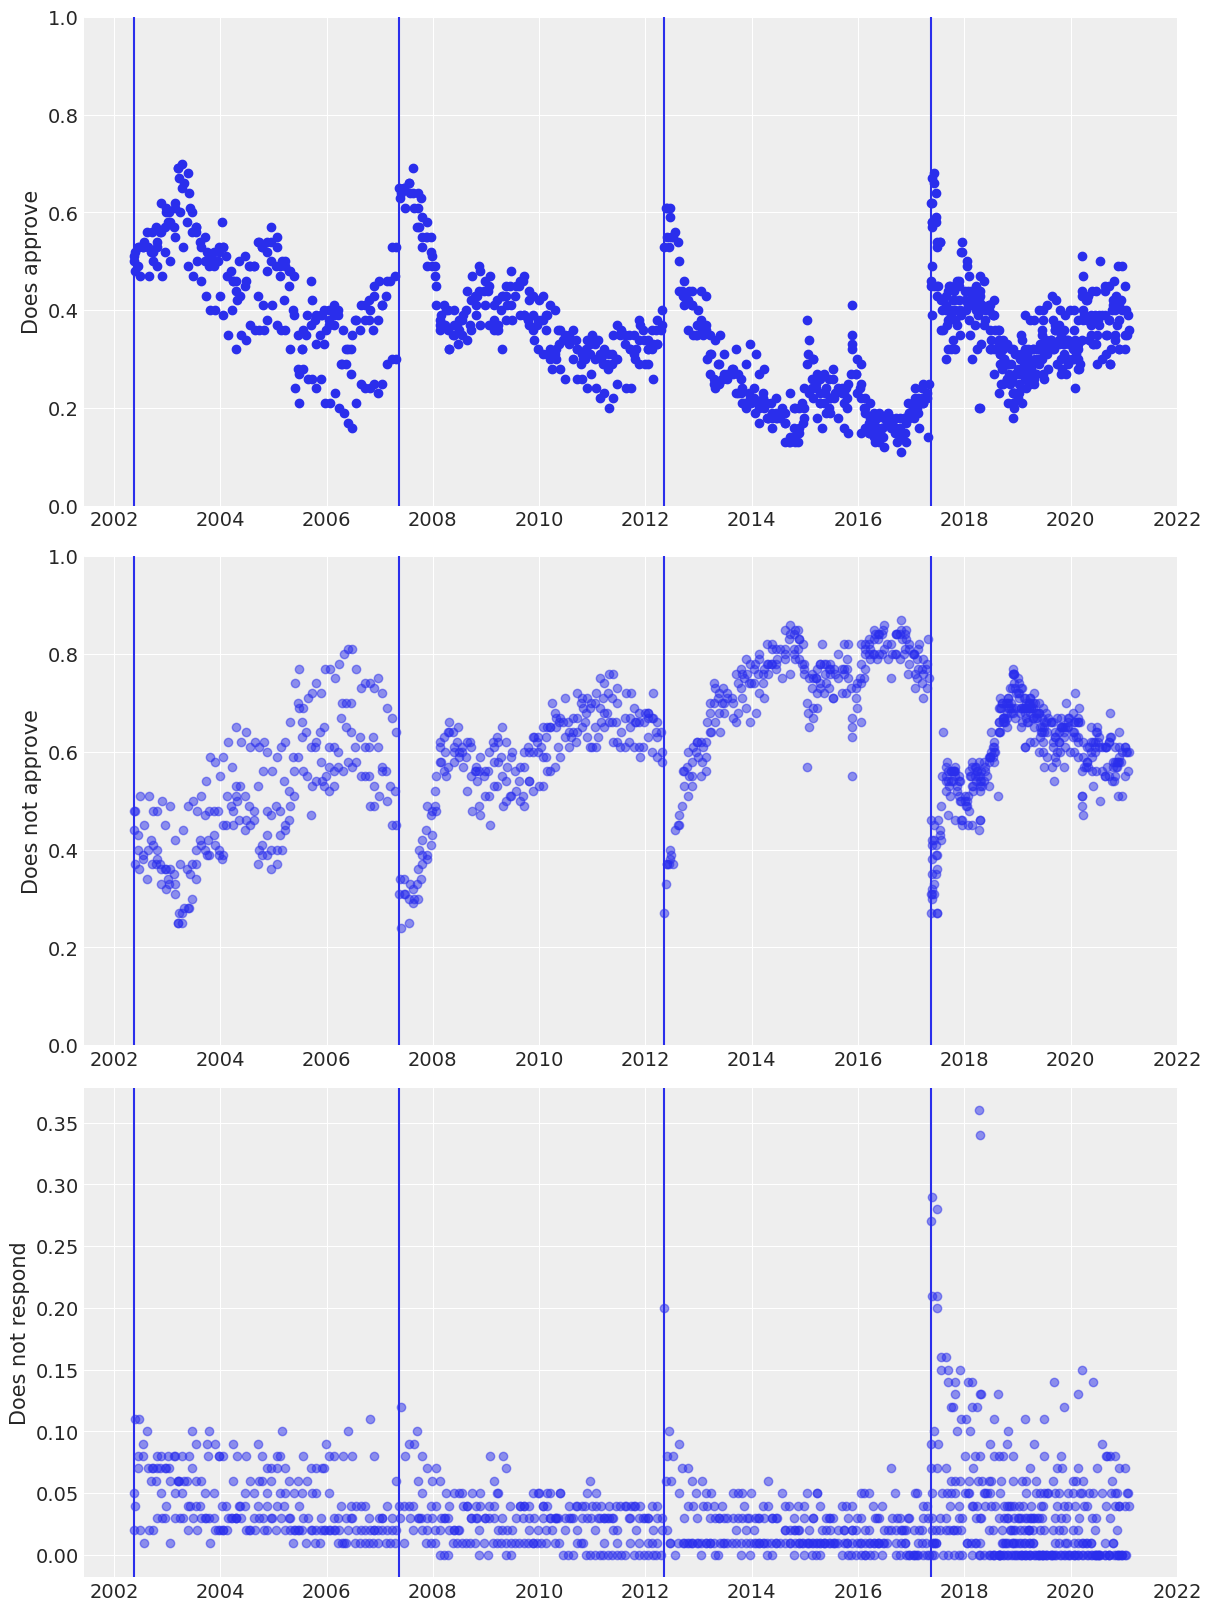

In [61]:
az.style.use("arviz-darkgrid")

approval_rates = data["p_approve"].values
disapproval_rates = data["p_disapprove"].values
newterm_dates = data.reset_index().groupby("president").first()["index"].values
doesnotrespond = 1 - approval_rates - disapproval_rates

dates = data.index

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,16))
ax1.plot(dates, approval_rates, 'o')
ax1.set_ylim(0, 1)
ax1.set_ylabel("Does approve")
for date in newterm_dates:
    ax1.axvline(date)

ax2.plot(dates, disapproval_rates, 'o', alpha=.5)
ax2.set_ylabel("Does not approve")
ax2.set_ylim(0, 1)
for date in newterm_dates:
    ax2.axvline(date)
    
ax3.plot(dates, doesnotrespond, 'o', alpha=.5)
ax3.set_ylabel("Does not respond")
for date in newterm_dates:
    ax3.axvline(date)

We notice two things when looking at these plots:

1. Approval rates strikingly systematically decrease as the terms comes along;
2. While that's true, some events seem to push the approval rate back up, even though temporarily. This happened in every term, actually. Can that variance be explained solely with a random walk?
3. Non-response rate is quite high during Macron's term.

## Computing the biais: naive method

### Method bias

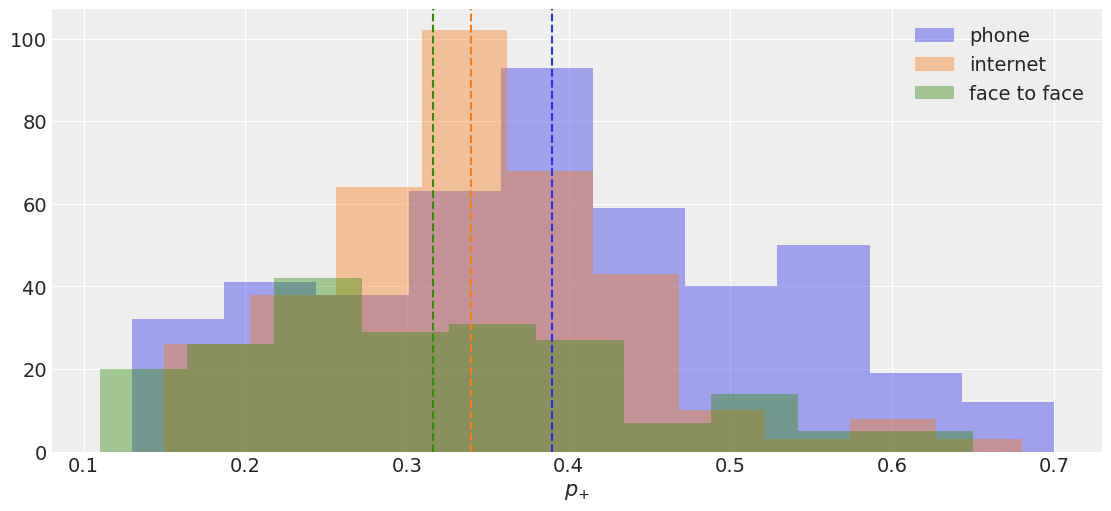

In [62]:
phone = data[data["method"] == "phone"]["p_approve"].values
internet = data[data["method"] == "internet"]["p_approve"].values
facetoface = data[data["method"] == "face to face"]["p_approve"].values

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots(figsize=(11,5))

c = next(colors)["color"]
ax.hist(phone, label="phone", color=c, alpha=.4)
ax.axvline(np.mean(phone), color=c, linestyle='--')

c = next(colors)["color"]
ax.hist(internet, label="internet", color=c, alpha=.4)
ax.axvline(np.mean(internet), color=c, linestyle='--')

c = next(colors)["color"]
ax.hist(facetoface, label="face to face", color=c, alpha=.4)
ax.axvline(np.mean(facetoface), color=c, linestyle='--')

ax.set_xlabel(r"$p_{+}$")
plt.legend();

### Pollster bias

We plot the distribution of the approval rates for each pollster. Note that this is not very scientific: pollsters like YouGov appeared recently so their rates will be tilted towards the last presidents' popularity while the other will be more evenly distributed.

It is already interesting to see that the bulk of the distributions is below 0.5:

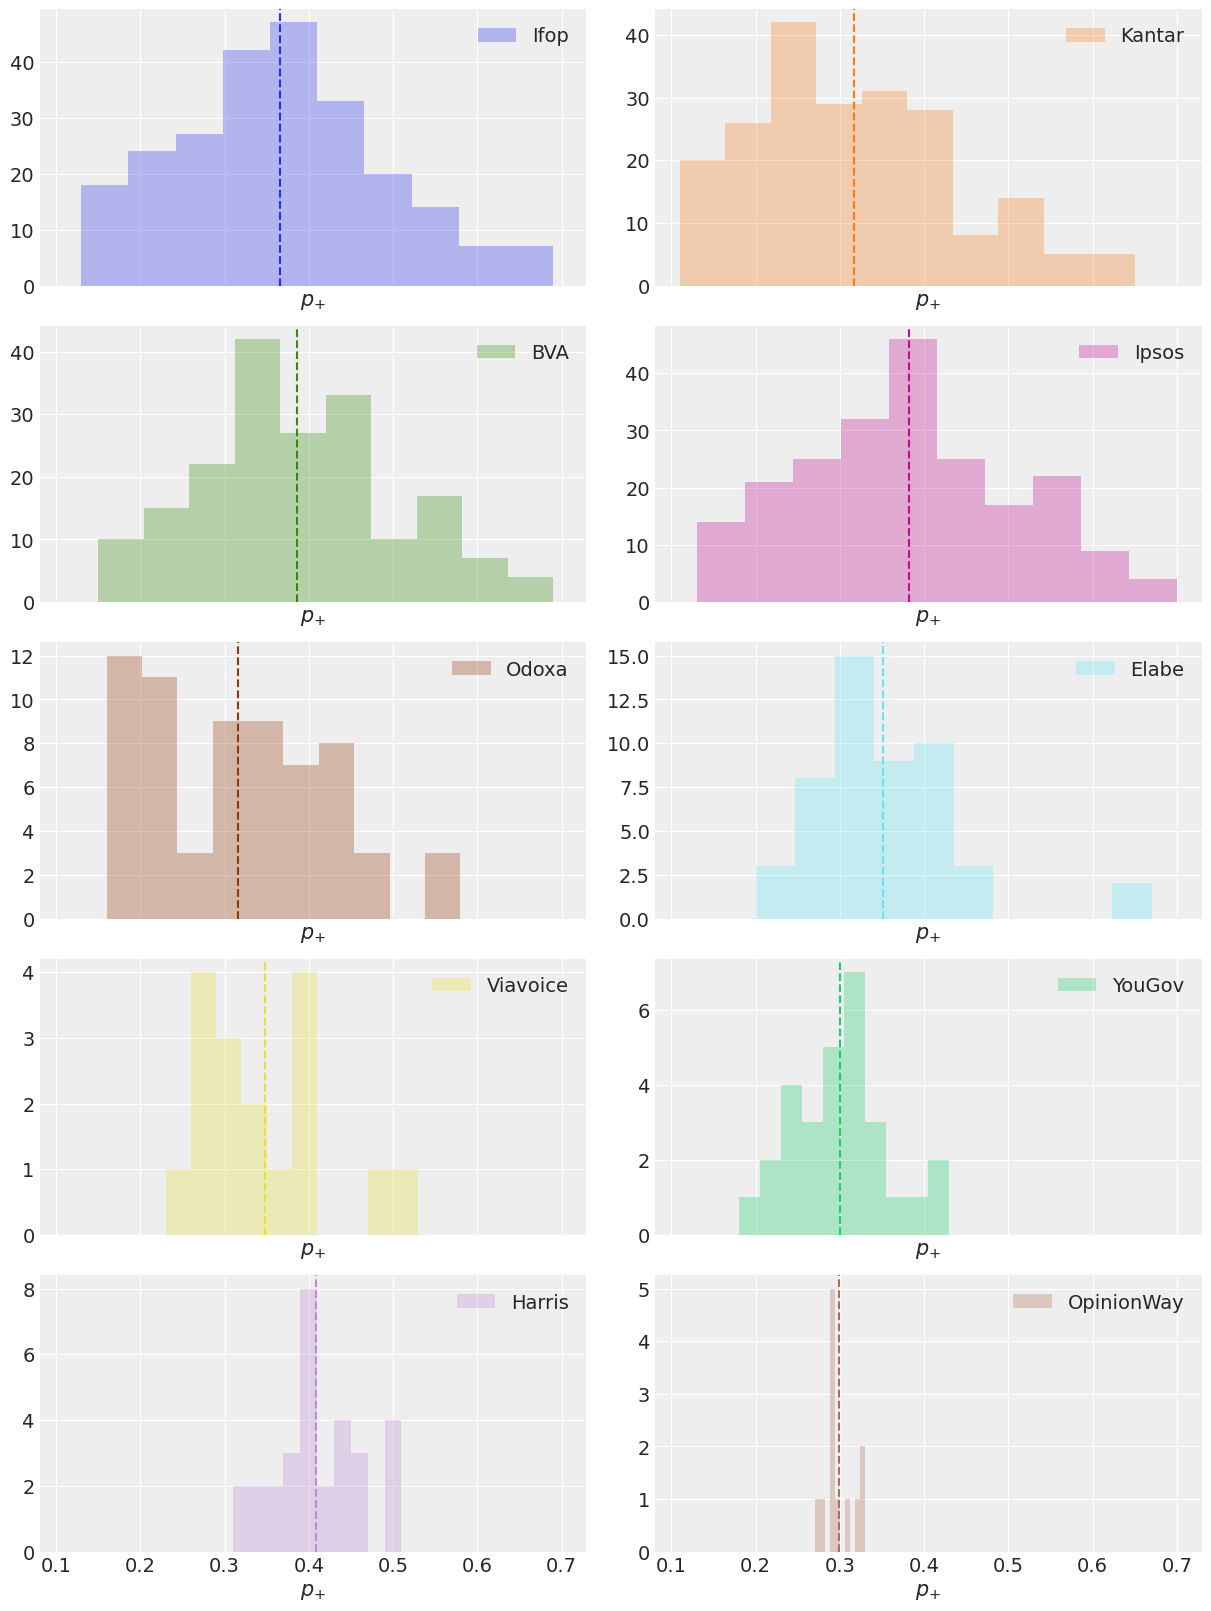

In [63]:
pollster_vals = {pollster: data[data["sondage"] == pollster]["p_approve"].values for pollster in list(pollsters)}

colors = plt.rcParams["axes.prop_cycle"]()
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12,16))
axes = [ax for axs in axes for ax in axs]
for ax, (pollster, vals) in zip(axes, pollster_vals.items()):
    c = next(colors)["color"]
    ax.hist(vals, alpha=.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle='--')
    ax.set_xlabel(r"$p_{+}$")
    ax.legend()

## Rolling standard deviation

We now compute the rolling variance of the approval rates. We weigh each poll equally, even though we probably should weigh them according to their respective sample size.

In [64]:
rolling_std = data.reset_index().groupby(['year', 'month']).std().reset_index()[["year", "month", "p_approve"]]
rolling_std

,year,month,p_approve
0,2002,5,0.017078
1,2002,6,0.030000
2,2002,7,0.005774
3,2002,8,0.045826
4,2002,9,0.025166
...,...,...,...
221,2020,10,0.045789
222,2020,11,0.046098
223,2020,12,0.072111
224,2021,1,0.046332


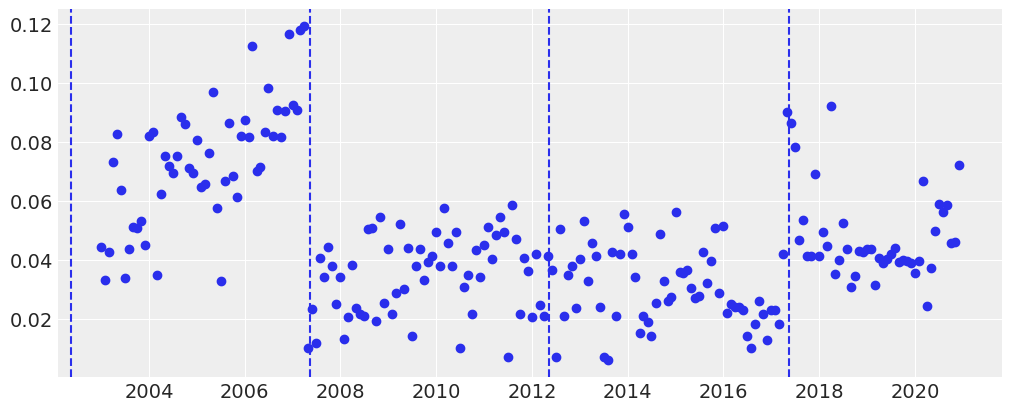

In [66]:
years = [f"{i}" for i in range(2003, 2021)]
values = rolling_std[rolling_std["year"].between(2003, 2020)]["p_approve"].values
dates = [datetime.datetime.strptime(f"{year}-{month}", '%Y-%m') for year in years for month in range(1, 13) ]

newterm_dates = data.reset_index().groupby("president").first()["index"].values

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dates, values, 'o')
for date in newterm_dates:
    ax.axvline(date, linestyle='--')

There is an abnormally high variance for Chirac's second term, and for the beggining of Macron's term. As a matter of fact, the previous scatterplot of $p_{approve}$ clearly shows almost two different curves. Let's look at the data for Chirac's term directly:

In [14]:
chirac = data[data["president"] == "chirac2"]
chirac2007 = chirac[chirac["year"] >= 2006]
chirac2007

,president,sondage,samplesize,method,p_approve,p_disapprove,year,month,month_name
2006-01-16,chirac2,Ifop,905,phone,0.37,0.61,2006,1,January
2006-01-17,chirac2,Ipsos,987,phone,0.38,0.57,2006,1,January
2006-01-19,chirac2,BVA,1043,phone,0.40,0.52,2006,1,January
2006-01-24,chirac2,Kantar,911,face to face,0.21,0.77,2006,1,January
2006-02-18,chirac2,BVA,953,phone,0.39,0.53,2006,2,February
2006-02-19,chirac2,Ipsos,971,phone,0.41,0.56,2006,2,February
2006-02-20,chirac2,Ifop,971,phone,0.37,0.61,2006,2,February
2006-02-26,chirac2,Kantar,933,face to face,0.23,0.75,2006,2,February
2006-03-17,chirac2,Ifop,982,phone,0.39,0.60,2006,3,March
2006-03-21,chirac2,Ipsos,1062,phone,0.40,0.57,2006,3,March


And now for the beggining of Macron's term:

In [15]:
macron = data[data["president"] == "macron"]
macron2017 = macron[macron["year"] == 2017]
macron2017.head(20)

,president,sondage,samplesize,method,p_approve,p_disapprove,year,month,month_name
2017-05-17,macron,Elabe,999,internet,0.45,0.46,2017,5,May
2017-05-20,macron,Ifop,973,phone,0.62,0.31,2017,5,May
2017-05-20,macron,Ipsos,1015,internet,0.46,0.27,2017,5,May
2017-05-21,macron,Viavoice,1006,internet,0.49,0.30,2017,5,May
2017-05-23,macron,BVA,1011,internet,0.62,0.35,2017,5,May
2017-05-23,macron,Odoxa,1014,internet,0.58,0.41,2017,5,May
2017-05-24,macron,Elabe,1051,internet,0.67,0.31,2017,5,May
2017-05-25,macron,YouGov,1008,internet,0.39,0.32,2017,5,May
2017-05-27,macron,Ipsos,2138,internet,0.58,0.42,2017,5,May
2017-05-27,macron,Kantar,1008,face to face,0.57,0.38,2017,5,May


For Chirac's term it seems that difference stems from the polling method; face-to-face approval rates seem to be much lower. Let's visualize it:

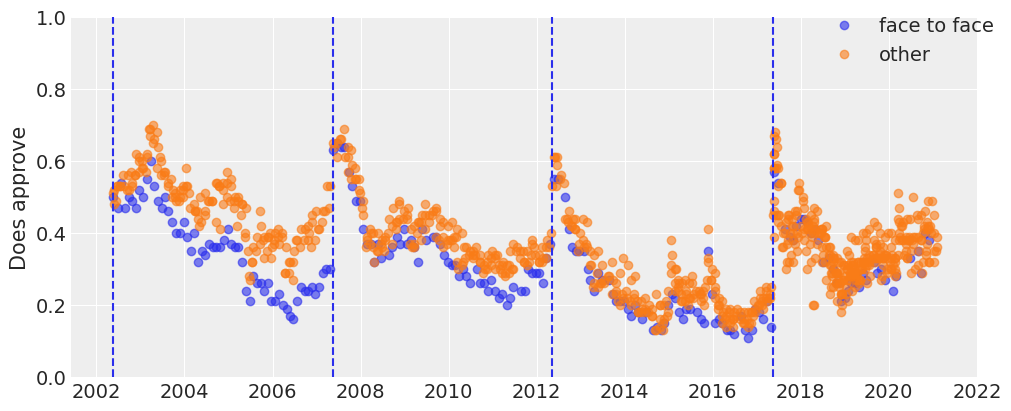

In [17]:
face = data[data['method'] == 'face to face']
dates_face = face.index

other = data[data['method'] != 'face to face']
dates_other = other.index

newterm_dates = data.reset_index().groupby("president").first()["index"].values


fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dates_face, face['p_approve'].values, 'o', alpha=0.4, label='face to face')
ax.plot(dates_other, other['p_approve'].values, 'o', alpha=0.4, label='other')
for date in newterm_dates:
    ax.axvline(date, linestyle='--')

ax.set_ylim(0, 1)
ax.set_ylabel("Does approve")
fig.legend();

In [18]:
data[data["sondage"] == "Kantar"]["method"].value_counts()

face to face             206
face-to-face&internet      1
internet                   1
Name: method, dtype: int64

In [19]:
data[data["method"] == "face to face"]["sondage"].value_counts()

Kantar    206
Name: sondage, dtype: int64

In [20]:
data[data["sondage"] == "Ifop"]["method"].value_counts()

phone             181
phone&internet     33
internet           25
Name: method, dtype: int64

## A more serious analysis of bias

To investigate bias we now compute the rolling mean of the $p_{approve}$ values and compare each method's and pollster's deviation from the mean.

In [73]:
data = data.reset_index().merge(data.groupby(['year', 'month'])['p_approve'].mean().reset_index(), on=['year', 'month'], suffixes=["", "_mean"]).rename(
    columns={"index": "field_date"}
)
data['diff_approval'] = data['p_approve'] - data['p_approve_mean']
data

,field_date,president,sondage,samplesize,method,p_approve,p_disapprove,year,month,month_name,p_approve_mean,diff_approval
0,2002-05-15,chirac2,Ifop,924,phone,0.51,0.44,2002,5,May,0.502500,0.007500
1,2002-05-20,chirac2,Kantar,972,face to face,0.50,0.48,2002,5,May,0.502500,-0.002500
2,2002-05-23,chirac2,BVA,1054,phone,0.52,0.37,2002,5,May,0.502500,0.017500
3,2002-05-26,chirac2,Ipsos,907,phone,0.48,0.48,2002,5,May,0.502500,-0.022500
4,2002-06-16,chirac2,Ifop,974,phone,0.49,0.43,2002,6,June,0.505000,-0.015000
...,...,...,...,...,...,...,...,...,...,...,...,...
1047,2021-01-08,macron,Ifop,1028,internet,0.45,0.55,2021,1,January,0.376667,0.073333
1048,2021-01-14,macron,Odoxa,1003,internet,0.40,0.60,2021,1,January,0.376667,0.023333
1049,2021-01-23,macron,Ipsos,1000,internet,0.35,0.60,2021,1,January,0.376667,-0.026667
1050,2021-01-31,macron,Kantar,2000,face-to-face&internet,0.39,0.56,2021,1,January,0.376667,0.013333


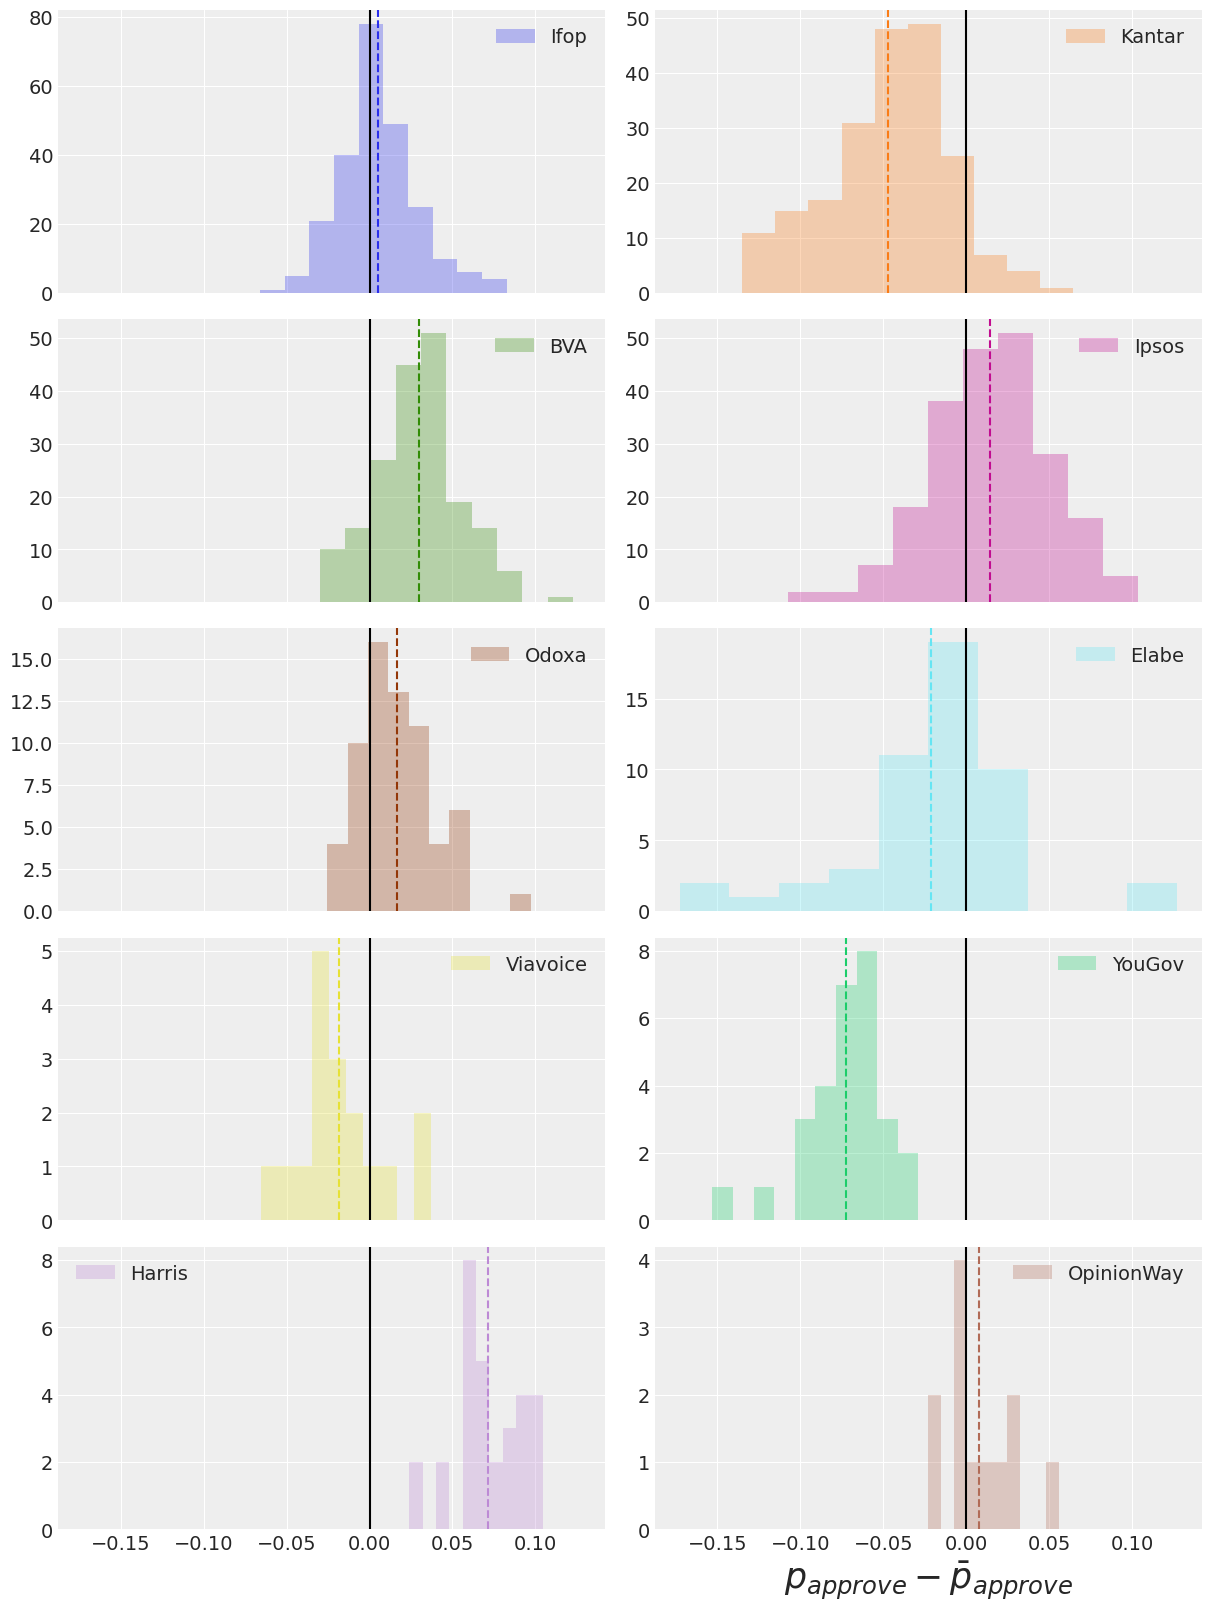

In [74]:
pollster_vals = {pollster: data[data["sondage"] == pollster]["diff_approval"].values for pollster in list(pollsters)}

colors = plt.rcParams["axes.prop_cycle"]()
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12,16))
axes = [ax for axs in axes for ax in axs]

for ax, (pollster, vals) in zip(axes, pollster_vals.items()):
    c = next(colors)["color"]
    ax.hist(vals, alpha=.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle='--')
    ax.axvline(x=0, color='black')
    ax.legend()

plt.xlabel(r"$p_{approve} - \bar{p}_{approve}$", fontsize=25);

And now for the bias per method:

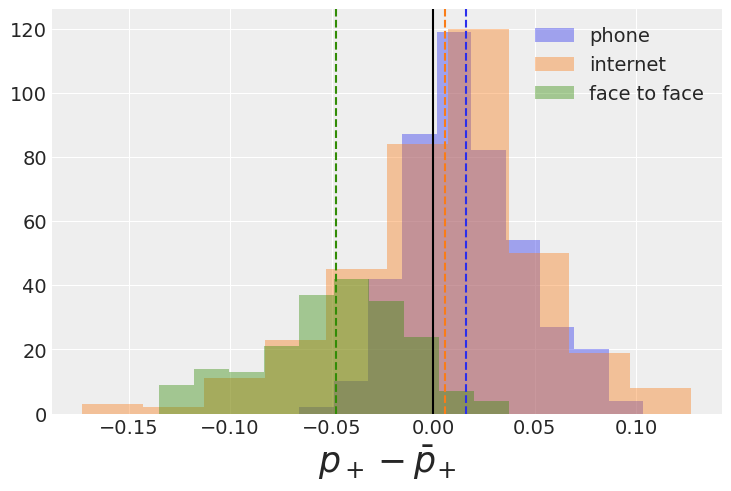

In [75]:
phone = data[data["method"] == "phone"]["diff_approval"].values
internet = data[data["method"] == "internet"]["diff_approval"].values
facetoface = data[data["method"] == "face to face"]["diff_approval"].values

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots()

c = next(colors)["color"]
ax.hist(phone, label="phone", color=c, alpha=.4)
ax.axvline(np.mean(phone), color=c, linestyle='--')

c = next(colors)["color"]
ax.hist(internet, label="internet", color=c, alpha=.4)
ax.axvline(np.mean(internet), color=c, linestyle='--')

c = next(colors)["color"]
ax.hist(facetoface, label="face to face", color=c, alpha=.4)
ax.axvline(np.mean(facetoface), color=c, linestyle='--')

ax.axvline(x=0, color="black")
ax.set_xlabel(r"$p_+ - \bar{p}_{+}$", fontsize=25)
plt.legend();

## Todo

### Bias

There are many things worth exploring before moving on to modeling. First, bias:

- Bias by method: does one method tend to produce higher approval rates? More non-response?

- We can use the rolling average by method/pollster and look at the distribution of the difference between values and the average per method/pollster.

### Variance

Look at a rolling estimate of the variance of approval rates.

### Trend

Look at the successive difference of the average approval rate. Is there a trend
here?

# Model

Each poll $i$ at month $m$ from the beginning of a president’s term finds that
$y_i$ individuals have a positive opinion of the president’s action over
$n_i$ respondents. We model this as

$$y_{i,m} \sim Binomial(p_{i,m}, n_{i,m})$$

We loosely call $p_{i,m}$ the *popularity* of the president, $m$ month into his
presidency. This is the quantity we would like to model.

Why specify the month when the time information is already contained in the
succession of polls? Because French people tend to be less and less satisfied
with their president as their term moves, regardless of their action.

We model $p_{i,m}$ with a random walk logistic regression:

$$p_{i,m} = logit^{-1}(\mu_m + \alpha_k + \zeta_j)$$

$\mu_m$ is the underlying support for the president at month $m$. $\alpha_k$ is
the bias of the pollster, while $\zeta_j$ is the inherent bias of the polling
method. The biases are assumed to be completely unpooled at first, i.e we model
one bias for each pollster and method:

$$\alpha_k \sim Normal(0, \sigma_k)\qquad \forall pollster k$$

and 

$$\zeta_j \sim Normal(0, \sigma_j)\qquad \forall method j$$

We treat the time variation of $\mu$ with a correlated random walk:

$$\mu_m | \mu_{m-1} \sim Normal(\mu_{m-1}, \sigma_m)$$

For the sake of simplicity, we choose not to account at first for a natural
decline in popularity $\delta$, the unmeployment at month $m$, $U_m$, or
random events that can happen during the term. 

In [76]:
data["num_approve"] = np.floor(data["samplesize"] * data["p_approve"]).astype('int')
pollster_id, pollsters = data["sondage"].factorize(sort=True)
method_id, methods = data["method"].factorize(sort=True)
month_correspondence = {i - 1: datetime.date(2021, i, 1).strftime('%B') for i in range(1, 13)}
month_id, months = (data["month"] - 1).values, list(month_correspondence.keys())

data

,field_date,president,sondage,samplesize,method,p_approve,p_disapprove,year,month,month_name,p_approve_mean,diff_approval,sondage_cat,method_cat,num_approve
0,2002-05-15,chirac2,Ifop,924,phone,0.51,0.44,2002,4,May,0.502500,0.007500,3,3,471
1,2002-05-20,chirac2,Kantar,972,face to face,0.50,0.48,2002,4,May,0.502500,-0.002500,5,0,486
2,2002-05-23,chirac2,BVA,1054,phone,0.52,0.37,2002,4,May,0.502500,0.017500,0,3,548
3,2002-05-26,chirac2,Ipsos,907,phone,0.48,0.48,2002,4,May,0.502500,-0.022500,4,3,435
4,2002-06-16,chirac2,Ifop,974,phone,0.49,0.43,2002,5,June,0.505000,-0.015000,3,3,477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047,2021-01-08,macron,Ifop,1028,internet,0.45,0.55,2021,0,January,0.376667,0.073333,3,2,462
1048,2021-01-14,macron,Odoxa,1003,internet,0.40,0.60,2021,0,January,0.376667,0.023333,6,2,401
1049,2021-01-23,macron,Ipsos,1000,internet,0.35,0.60,2021,0,January,0.376667,-0.026667,4,2,350
1050,2021-01-31,macron,Kantar,2000,face-to-face&internet,0.39,0.56,2021,0,January,0.376667,0.013333,5,1,780


Each observation is uniquely identified by (president, pollster, field_date):

In [91]:
COORDS = {
    "pollster": pollsters,
    "method": methods,
    "month": months,
    "observation": data.set_index(["president", "sondage", "field_date"]).index
}

In [92]:
with pm.Model(coords=COORDS) as pooled_popularity:
    
    pollster_bias = pm.Normal("pollster_bias", 0, .15, dims="pollster")
    method_bias = pm.Normal("method_bias", 0, .15, dims="method")
    # sigma_mu = pm.HalfNormal("sigma_mu", .1)
    mu = pm.GaussianRandomWalk(
        "mu",
        sigma=.25,
        dims="month"
        )

    popularity = pm.Deterministic(
        "popularity",
        pm.math.invlogit(mu[month_id] + pollster_bias[pollster_id] + method_bias[method_id]),
        dims="observation"
    )

    N_approve = pm.Binomial("N_approve", p=popularity, n=data["samplesize"], observed=data["num_approve"], dims="observation")

In [93]:
with pooled_popularity:
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, method_bias, pollster_bias]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
The number of effective samples is smaller than 25% for some parameters.


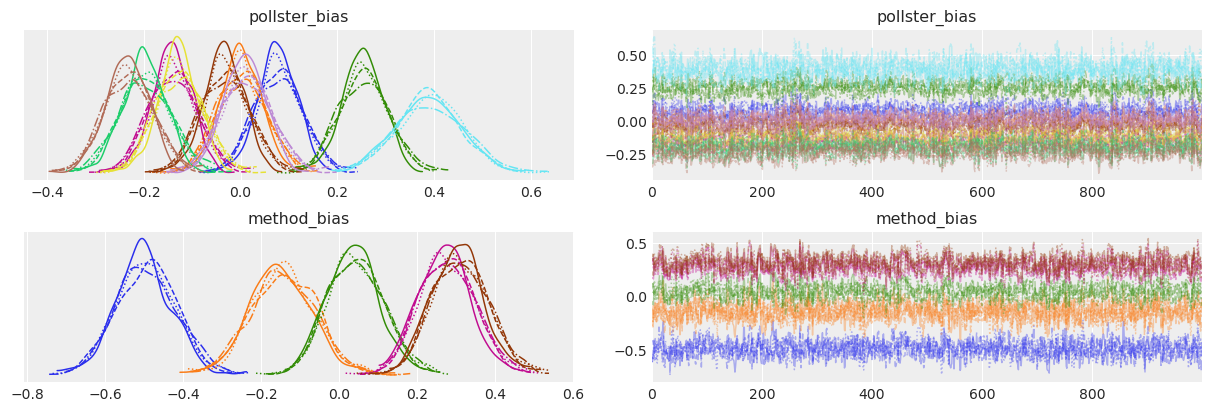

In [108]:
az.plot_trace(idata, var_names=['pollster_bias', 'method_bias'], compact=True);

In [109]:
from scipy.special import expit as logistic

In [110]:
idata.posterior["mu"]

<xarray.DataArray 'mu' (chain: 4, draw: 1000, month: 12)>
array([[[-0.54336546, -0.64461083, -0.61140587, ..., -0.60562464,
         -0.56205694, -0.55027831],
        [-0.55436224, -0.65434406, -0.61808791, ..., -0.61756177,
         -0.57685537, -0.56967178],
        [-0.55690972, -0.65517506, -0.60816664, ..., -0.6181009 ,
         -0.56601889, -0.57131765],
        ...,
        [-0.6226018 , -0.73248092, -0.69245059, ..., -0.69270583,
         -0.64842875, -0.63665684],
        [-0.64924413, -0.73121463, -0.69116516, ..., -0.69659965,
         -0.63958507, -0.64341779],
        [-0.72416005, -0.83437092, -0.79237614, ..., -0.79343166,
         -0.75369438, -0.73963084]],

       [[-0.75784226, -0.82977859, -0.80200492, ..., -0.80515935,
         -0.73810237, -0.75143473],
        [-0.74624905, -0.8207454 , -0.79200947, ..., -0.79197755,
         -0.72505616, -0.74080512],
        [-0.73299298, -0.80801547, -0.77648245, ..., -0.7879451 ,
         -0.73689672, -0.73508028],
...
        [-0.54817086, -0.6471178 , -0.60970321, ..., -0.61079341,
         -0.54921614, -0.54940756],
        [-0.54589837, -0.64601464, -0.61496331, ..., -0.61759453,
         -0.54280655, -0.55123442],
        [-0.58472283, -0.67169853, -0.62469881, ..., -0.62226543,
         -0.5884299 , -0.57742776]],

       [[-0.59508327, -0.68337882, -0.65003044, ..., -0.66608053,
         -0.59337206, -0.61229786],
        [-0.60300131, -0.69455618, -0.65640091, ..., -0.65984477,
         -0.61768275, -0.62621827],
        [-0.61182353, -0.7013086 , -0.65766922, ..., -0.66798527,
         -0.62145759, -0.63238602],
        ...,
        [-0.43823445, -0.53506901, -0.49810969, ..., -0.4929578 ,
         -0.45252291, -0.44754406],
        [-0.45497602, -0.55283791, -0.51439467, ..., -0.5208863 ,
         -0.47571101, -0.46579495],
        [-0.53331525, -0.62378719, -0.57757402, ..., -0.590778  ,
         -0.52985797, -0.55237761]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * month    (month) int64 0 1 2 3 4 5 6 7 8 9 10 11

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(range(60), np.mean(inv_logit(posterior['mu']), axis=0))
ax.plot(range(60), np.var(inv_logit(posterior['mu']), axis=0))
ax.set_ylabel("Popularity")
ax.set_xlabel("Months into term");

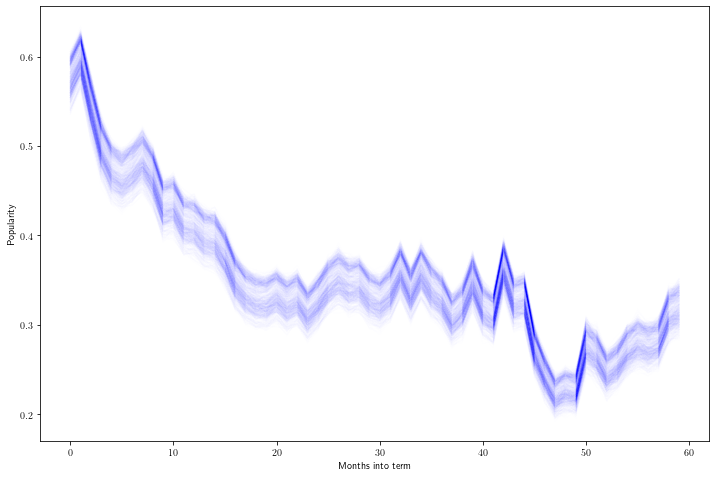

In [44]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

fig, ax = plt.subplots(figsize=(12,8))
for i in range(1000):
    ax.plot(range(60), inv_logit(posterior['mu'][i,:]), alpha=.005, color="blue")
ax.set_ylabel("Popularity")
ax.set_xlabel("Months into term");

In [ ]:
np.mean(inv_logit(posterior['alpha_p']), axis=0)

In [ ]:
np.mean(inv_logit(posterior['alpha_m']), axis=0)

In [ ]:
pd.Categorical(data['method']).unique()